# Robustness
The final process in the analysis is evaluating the robustness of the candidate solutions that came out of the optimization. This is done with the following steps:
- The model is ran with 1000 newly sampled scenarios per candidate policy
- The signal to noise ratio scores are calculated for each policy
- A final policy recommendation is made considering the robustness of the different policies

In [19]:
# Importing the needed packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from ema_workbench import (
    Model,
    Policy,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    Scenario,
    ema_logging,
    ScalarOutcome
)

import pickle
from ema_workbench.analysis import parcoords
from problem_formulation import get_model_for_problem_formulation
ema_logging.log_to_stderr(ema_logging.INFO)
from ema_workbench.em_framework.optimization import to_problem

In [2]:
# Once again the model is initiated to run the model with new scenarios
dike_model, planning_steps = get_model_for_problem_formulation(6)
epsilons = [1000, 1000, 0.25, 1000, 1000, 1000, 1000, 1000, 1000, 1000]

# Direction of scalar outcomes is needed to calculate signal to noise ratio later on
dike_model.outcomes = [ScalarOutcome("A.2_Expected Annual Damage", kind=ScalarOutcome.MINIMIZE, function=sum),
                       ScalarOutcome("A.2_Expected Number of Deaths", kind=ScalarOutcome.MINIMIZE, function=sum),
                       ScalarOutcome("A.2_Dike Investment Costs", kind=ScalarOutcome.MINIMIZE, function=sum),
                       ScalarOutcome("RfR Total Costs", kind=ScalarOutcome.MINIMIZE, function=sum)]

problem = to_problem(dike_model, searchover="levers")


In [3]:
# The top 10 solutions with lowest deaths from the multi-scenario MORDM is loaded here
with open('dominatingSolutions', 'rb') as f:
    solutions = pickle.load(f)

In [4]:
all_policies = solutions

In [5]:
# Only the policies are needed, not the outcomes which is why they are dropped
all_policies = all_policies.drop(columns=['A.2_Expected Annual Damage', 'A.2_Dike Investment Costs',
       'A.2_Expected Number of Deaths', 'RfR Total Costs',
       'Expected Evacuation Costs', 'RfR 0 Individual Costs',
       'RfR 1 Individual Costs', 'RfR 2 Individual Costs',
       'RfR 3 Individual Costs', 'RfR 4 Individual Costs'])

In [22]:
all_policies

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
52,0,0,0,0,0,0,1,1,1,0,...,0,7,2,3,4,5,5,2,2,7
54,0,0,0,0,0,0,1,0,0,1,...,0,0,3,5,6,1,7,2,6,1
79,0,0,0,0,0,0,1,0,1,1,...,0,2,5,2,7,5,0,1,5,5
66,0,0,0,0,0,0,1,1,1,0,...,0,6,2,7,5,6,2,7,5,5
85,0,0,0,0,0,0,1,0,1,1,...,0,3,5,1,4,0,4,2,2,4
73,0,0,0,0,0,0,0,0,1,0,...,0,6,4,2,4,7,6,6,4,4
65,0,0,0,0,0,0,1,1,1,1,...,0,10,5,5,4,3,3,5,3,7
48,0,0,0,0,0,0,1,1,0,1,...,0,7,5,4,5,0,6,5,2,4
49,0,0,0,0,0,0,1,0,1,0,...,0,6,3,3,6,1,5,2,6,7
72,0,0,0,0,0,0,1,1,1,1,...,0,5,7,7,5,5,4,1,2,4


## Performing Experiments for Candidate Policies
From the dataframe containing the candidate policies, EMA Workbench Policy objects are made. This way, they can be used as input in the model. Then, the model is ran for the 10 candidate policies, with 1000 newly generated scenarios with different values for all the uncertainties (generated with the latin hypercube technique). This way, it can be tested whether the candidate policies consitently perform well, and not just in specific worst case scenarios.

In [6]:
policies_to_evaluate = []

# Storing policies from df as Policy objects as input for the model
for i, policy in all_policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [11]:
# n_scenarios = 1000
# with MultiprocessingEvaluator(dike_model) as evaluator:
#     results = evaluator.perform_experiments(n_scenarios,
#                                             policies_to_evaluate)

[MainProcess/INFO] pool started with 12 workers
[MainProcess/INFO] performing 1000 scenarios * 10 policies * 1 model(s) = 10000 experiments
100%|████████████████████████████████████| 10000/10000 [31:58<00:00,  5.21it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [13]:
# # Saving experiment results as file, so the model doesn't have to run again when this file is reopened
# with open('robustResults', 'wb') as f:
#     pickle.dump(results, f)

In [7]:
with open('robustResults', 'rb') as f:
    results = pickle.load(f)

In [8]:
experiments, outcomes = results

In [9]:
outcomes_df = pd.DataFrame(outcomes)
outcomes_df

,A.2_Expected Annual Damage,A.2_Dike Investment Costs,A.2_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,RfR 0 Individual Costs,RfR 1 Individual Costs,RfR 2 Individual Costs,RfR 3 Individual Costs,RfR 4 Individual Costs
0,0.0,4.784270e+07,0.0,334500000.0,0.0,0,0,92100000,242400000,0
1,0.0,4.784270e+07,0.0,334500000.0,0.0,0,0,92100000,242400000,0
2,0.0,4.784270e+07,0.0,334500000.0,0.0,0,0,92100000,242400000,0
3,0.0,4.784270e+07,0.0,334500000.0,0.0,0,0,92100000,242400000,0
4,0.0,4.784270e+07,0.0,334500000.0,0.0,0,0,92100000,242400000,0
...,...,...,...,...,...,...,...,...,...,...
9995,0.0,4.281842e+07,0.0,967900000.0,0.0,0,0,92100000,363600000,512199999
9996,0.0,4.281842e+07,0.0,967900000.0,0.0,0,0,92100000,363600000,512199999
9997,0.0,4.281842e+07,0.0,967900000.0,0.0,0,0,92100000,363600000,512199999
9998,0.0,4.281842e+07,0.0,967900000.0,0.0,0,0,92100000,363600000,512199999


## Robustness Metrics
Next, the robustness metrics for the policies are calculated. This is done with code based on the course's GitHub repository [(Kwakkel, 2024)](https://github.com/quaquel/epa141A_open/blob/master/Week%205-6%20-%20robustness%20and%20direct%20search/assignment%209%20-%20model%20answer.ipynb). The chosen robustness metric is the signal to noise ratio, which is calculated by multiplying the mean of a policy outcome across scenarios with the standard deviation of that policy outcome across scenarios (for outcomes which are minimized). Therefore, a low signal to noise ratio is desired, as it indicates a robust policy with outcomes that don't vary a lot. 

In [10]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    # For our model, outcomes are only minimized
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [11]:
overall_scores = {}
# Iterate over each unique policy in the dataframe
for policy in np.unique(experiments['policy']):
    scores = {}
    logical = experiments['policy']==policy
    
    # Iterate over each outcome in the model and calculate signal to noise ratio
    for outcome in dike_model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio

    # Store the scores dictionary in the overall_scores dictionary for the current policy
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T

scores
# Scores are saved for easy access later on
scores.to_csv('optimized_scores.csv')

From the multi-scenario MORDM, it seemed that policy 52 and 54 were favorite, as they led to zero deaths in their respective worst case scenarios. When tested with a 1000 newly generated scenarios though, there seems to be a slightly higher expected number of deaths in some scenarios for these policies. The policies still seem to be very robust though as only policy 65 and 79 are more robust in terms of deaths. There are more deaths, however, in general with these policies, which is why policy 52 and 54 remain better options. The final recommendation is policy 52, as it is more robust than 54 in terms of expected number of deaths and expected annual damage. Finally, something to note is that Room for River costs and dike investment costs all have a signal to noise ratio of zero. This is expected, because these costs are directly linked to the levers and are therefore not influenced by different uncertainties across scenarios. Below, the scores are visualized using parallel coordinate plotting.

In [12]:
scores

,A.2_Expected Annual Damage,A.2_Dike Investment Costs,A.2_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,RfR 0 Individual Costs,RfR 1 Individual Costs,RfR 2 Individual Costs,RfR 3 Individual Costs,RfR 4 Individual Costs
48,8.997866e+14,0.0,0.000666,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
49,1.175632e+15,0.0,0.000866,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
52,5.495198e+14,0.0,0.000395,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
54,6.093961e+14,0.0,0.000461,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
65,1.212285e+15,0.0,0.000109,0.0,3.868741e+07,0.0,0.0,0.0,0.0,0.0
66,6.610617e+14,0.0,0.000476,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
72,1.212285e+15,0.0,0.000842,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
73,7.395648e+14,0.0,0.000562,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
79,7.499978e+14,0.0,0.000071,0.0,3.886177e+07,0.0,0.0,0.0,0.0,0.0
85,7.499978e+14,0.0,0.000548,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0


c:\Users\tbous\Anaconda3\envs\MBDM\lib\site-packages\ema_workbench\analysis\parcoords.py:220: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


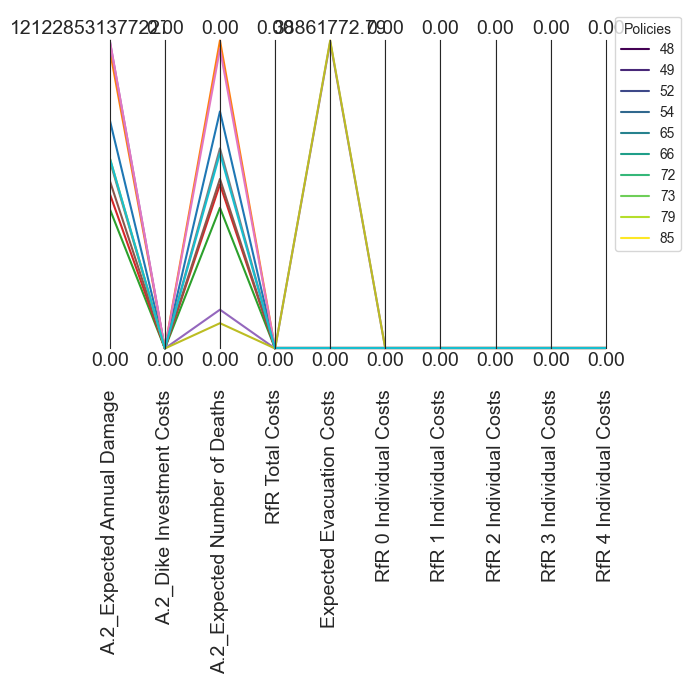

In [20]:
data_scores = scores
limits = parcoords.get_limits(data_scores)

# 0 is set as one of the limits for each variable
limits.loc[0, ['A.2_Expected Annual Damage', 'A.2_Dike Investment Costs',
                         'A.2_Expected Number of Deaths','RfR Total Costs',
                           'Expected Evacuation Costs','RfR 2 Individual Costs',
                            'RfR 3 Individual Costs']] = 0

# Using parallel coordinate plotting to visualize scores
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data_scores)

# Create a color map for the policies
num_policies = len(data_scores)
colors = plt.cm.viridis(np.linspace(0, 1, num_policies))

# Create a legend linking the lines to specific policies
legend_handles = []
for index, label in enumerate(data_scores.index):
    color = colors[index]  # Assign a unique color to each policy
    legend_handles.append(mlines.Line2D([], [], color=color, label=label))

# Add the legend to the plot
plt.legend(handles=legend_handles, title='Policies', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

## Policy Recommendation

The final recommended policy, as stated above, is policy 52. In this policy, RfR 2 is introduced at timestep 0, while RfR 3 is introduced at timestep 1. Furthermore, EWS_DaysToThreat remains 0. Next to that, A2 gets increased by 3 meter, A1 doesn't get a dike increase, while other dikes are increased with varying amounts. The average dike increase is about the same as in the whole solution space, with a 2.66 m average. For our actor, this specific policy leads to the best performance across different scenarios as pointed out by the analysis. However, in the real world, it is hard to adhere to very specific values, which means that the whole solution space can still be taken into account and should perform relatively well and robust as well, as most robustness scores were similar. 

In [21]:
best_solution = all_policies.loc[52]
best_solution

0_RfR 0               0
0_RfR 1               0
0_RfR 2               0
1_RfR 0               0
1_RfR 1               0
1_RfR 2               0
2_RfR 0               1
2_RfR 1               1
2_RfR 2               1
3_RfR 0               0
3_RfR 1               1
3_RfR 2               1
4_RfR 0               0
4_RfR 1               0
4_RfR 2               0
EWS_DaysToThreat      0
A.1_DikeIncrease 0    0
A.1_DikeIncrease 1    0
A.1_DikeIncrease 2    0
A.2_DikeIncrease 0    3
A.2_DikeIncrease 1    0
A.2_DikeIncrease 2    0
A.3_DikeIncrease 0    7
A.3_DikeIncrease 1    2
A.3_DikeIncrease 2    3
A.4_DikeIncrease 0    4
A.4_DikeIncrease 1    5
A.4_DikeIncrease 2    5
A.5_DikeIncrease 0    2
A.5_DikeIncrease 1    2
A.5_DikeIncrease 2    7
Name: 52, dtype: int64

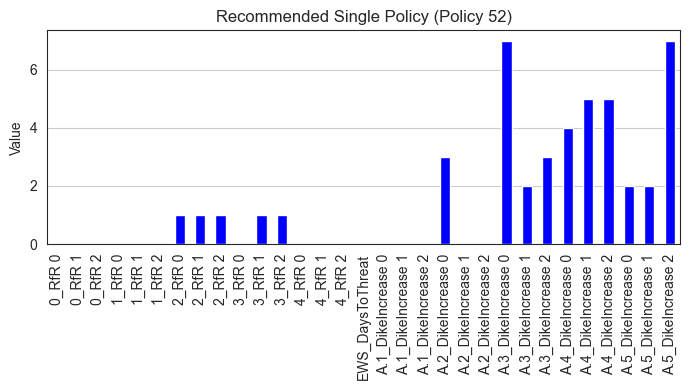

In [ ]:
# Plot the values of the recommended policy in a clear overview
plt.figure(figsize=(7,4))
best_solution.plot(kind='bar', color='blue')
plt.title('Recommended Single Policy (Policy 52)')
plt.ylabel('Value')
plt.xticks(rotation=90)
plt.grid(axis='y')

plt.tight_layout()
plt.show()

In [ ]:
dike_increase = best_solution[['A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2']]

print('Average dike increase accross all dikes:', np.mean(dike_increase.values))

Average dike increase accross all dikes: 2.6666666666666665
